In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.8 MB/s 
     |████████████████████████████████| 128 kB 9.6 MB/s 
     |████████████████████████████████| 4.0 MB 53.7 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 112 kB 61.9 MB/s 
     |████████████████████████████████| 110 kB 48.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

#Getting Stock Data

In [ ]:
def get_stock_data(data): #returns closing prices of the stocks in data

  stock_data = yf.download(data, start="2019-12-10" ,end= "2022-12-10")

  return stock_data

#Double Exponential Moving Average

##Calculating Double Exponential Moving Average

\begin{align}
  DEMA_n = 2 × EMA_n - EMA\;of\;EMA_n
\end{align}

where<br>
$n$ is the look back period

In [ ]:
def double_exponential_moving_average(data, period): # returns double exponential moving average of the series data with a n = period

  ema = data.ewm(span=period).mean()
  ema_of_ema = ema.ewm(span=period).mean()

  dema = 2 * ema - ema_of_ema

  dema.dropna(inplace=True)

  return dema

Here, 

short_double_exponential_moving_average_series has $n = 20$<br>
long_double_exponential_moving_average_series has $n = 50$

In [ ]:
short_double_exponential_moving_average_series = double_exponential_moving_average(closing_prices, 20)
long_double_exponential_moving_average_series = double_exponential_moving_average(closing_prices, 50)
short_double_exponential_moving_average_series

Date
2019-12-10    297.422333
2019-12-11    298.076137
2019-12-12    299.780595
2019-12-13    300.560891
2019-12-16    301.819661
                 ...    
2022-12-05    402.533744
2022-12-06    401.331820
2022-12-07    400.142575
2022-12-08    399.645607
2022-12-09    398.656966
Name: Adj Close, Length: 757, dtype: float64

##Plotting Long and Short DEMAs

In [ ]:
def plot_double_exponential_moving_averages(dema_series_long, dema_series_short, data): # plots long and short DEMA with stock closing prices

  plt.figure(figsize=(14,6),)
  l1 = plt.plot(data, c='g')
  l2 = plt.plot(dema_series_long, c='red')
  l3 = plt.plot(dema_series_short, c='orange')
  plt.ylabel('Stock Closing Price')
  plt.xlabel('Date')
  plt.title('Stock Closing Price Along with Double Exponential Moving Averages')
  plt.legend(['Stock Closing Price', 'Long Double Exponential Moving Average', 'Short Double Exponential Moving Average'], loc='upper left');


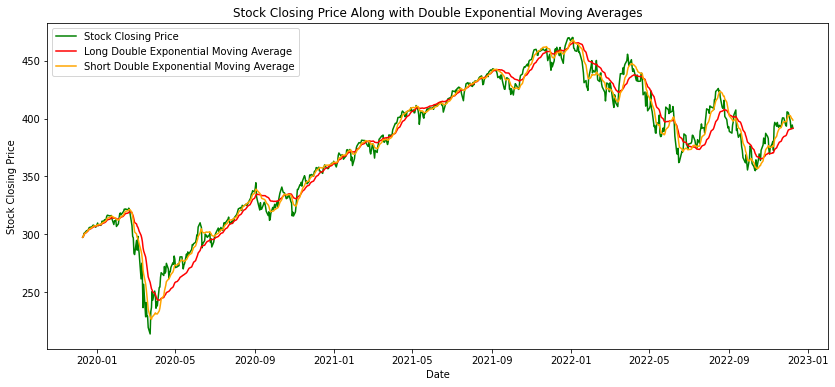

In [ ]:
plot_double_exponential_moving_averages(long_double_exponential_moving_average_series, short_double_exponential_moving_average_series, closing_prices)

##Strategy

When<br> 
Short DEMA crosses above long DEMA, buy.<br>
Short DEMA crosses below long DEMA, sell.


In [ ]:
def generating_trading_signals(data, short_dema, long_dema): # generates a dataframe signal which will be used to plot trading signals and calculate CAGR

  signal = pd.DataFrame()
  signal['Close'] = data
  signal['Short DEMA'] = short_dema
  signal['Long DEMA'] = long_dema
  buy_price = []
  sell_price = []

  #flag is true when short DEMA > long DEMA
  #flag is false when long DEMA > short DEMA
  #This variable ensures trades only happen when the two lines cross
  flag = False

  for i in range(0, len(data)):

    if signal['Short DEMA'][i] > signal['Long DEMA'][i] and flag == False:
      buy_price.append(signal['Close'][i])
      sell_price.append(np.nan)
      flag = True

    elif signal['Long DEMA'][i] > signal['Short DEMA'][i] and flag == True:
      buy_price.append(np.nan)
      sell_price.append(signal['Close'][i])
      flag = False

    else:
      buy_price.append(np.nan)
      sell_price.append(np.nan)

  signal['Buy'] = buy_price
  signal['Sell'] = sell_price
  
  return signal

In [ ]:
signals = generating_trading_signals(closing_prices, short_double_exponential_moving_average_series, long_double_exponential_moving_average_series)
signals

,Close,Short DEMA,Long DEMA,Buy,Sell
Date,,,,,
2019-12-10,297.422333,297.422333,297.422333,NaN,NaN
2019-12-11,298.266632,298.076137,298.063916,298.266632,NaN
2019-12-12,300.837402,299.780595,299.701663,NaN,NaN
2019-12-13,301.017639,300.560891,300.465689,NaN,NaN
2019-12-16,303.085663,301.819661,301.648304,NaN,NaN
...,...,...,...,...,...
2022-12-05,397.763458,402.533744,390.815534,NaN,NaN
2022-12-06,392.029785,401.331820,391.018453,NaN,NaN
2022-12-07,391.362854,400.142575,391.156042,NaN,NaN


##Plotting Trading Signals

In [ ]:
def plotting_signals_data(signal): # plots important columns from signal

  plt.figure(figsize=(14,6),)
  l1 = plt.plot(signal['Close'], c='blue', alpha=0.4)
  l2 = plt.plot(signal['Long DEMA'], c='yellow', alpha=0.4)
  l3 = plt.plot(signal['Short DEMA'], c='orange', alpha=0.4)
  plt.scatter(signal.index, signal['Buy'], c='green', label='Buy Signal', marker='^')
  plt.scatter(signal.index, signal['Sell'], c='red', label='Sell Signal', marker='v')
  plt.ylabel('Stock Closing Price')
  plt.xlabel('Date')
  plt.title('Sell Signal Plot')
  plt.legend(['Stock Closing Price', 'Long Double Exponential Moving Average', 'Short Double Exponential Moving Average'], loc='upper left');

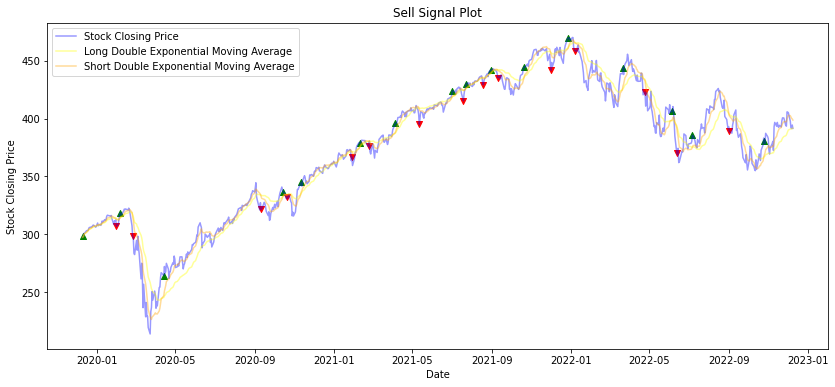

In [ ]:
plotting_signals_data(signals)

##Calculating CAGR

In [ ]:
def profit_and_loss_calculation(signal): # calculated CAGR with signal dataframe

  #In this function i assume that we start off with a capital of 100,000
  #Upon encountering a buy signal no_of_stocks amount of stocks are bought
  #Upon encountering a sell signal no_of_stocks amount of stocks are sold
  #In the end of the simulation, all stocks held are sold off at the current market price
  initial_capital = 100000
  no_of_stocks = initial_capital // max(signal['Close'])
  assets_in_cash = 100000
  stocks_held = 0
  buy_check = signal['Buy'].isna()
  sell_check = signal['Sell'].isna()

  for i in range(0, len(signal)):
    
    if buy_check[i] == False:
      assets_in_cash -= no_of_stocks * signal['Buy'][i]
      stocks_held += no_of_stocks

    if sell_check[i] == False:
      assets_in_cash += no_of_stocks * signal['Sell'][i]
      stocks_held -= no_of_stocks

  final_assets = assets_in_cash + stocks_held * signal['Close'][len(signal) - 1]
  no_of_days = (signal.index[-1] - signal.index[0]).days
  returns = ((final_assets / initial_capital) ** (float(no_of_days) / (3 * 365)) - 1) * 100
  
  return returns

CAGR of The Double Exponential Moving Average Strategy Explained Above

In [ ]:
print('CAGR =', profit_and_loss_calculation(signals), '%')

CAGR = -2.7746651611328166 %


#Average Directional Index



##Getting Stock Data

In [ ]:
data = ['SPY']
stock_df = get_stock_data(data)
stock_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-10,313.820007,314.549988,312.809998,313.529999,297.422302,52649800
2019-12-11,314.029999,314.700012,313.440002,314.420013,298.266632,53429100
2019-12-12,314.429993,317.989990,314.170013,317.130005,300.837402,96389600
2019-12-13,316.869995,318.670013,316.019989,317.320007,301.017639,81503900
2019-12-16,319.220001,320.149994,317.250000,319.500000,303.085632,82749700
...,...,...,...,...,...,...
2022-12-05,403.950012,404.929993,398.170013,399.589996,397.763458,77289800
2022-12-06,399.420013,399.989990,391.640015,393.829987,392.029785,77972200
2022-12-07,392.940002,395.640015,391.970001,393.160004,391.362854,65927900


##Calculating True Range

\begin{align}
  TR = max(H - L, |H - P.C|, |L - P.C|)
\end{align}

where,<br>
$TR$ is the true range,<br>
$H$ is the current high,<br>
$L$ is the current low,<br>
$P.C$ is the previous close

In [ ]:
def calculate_true_range(data):

  high = data['High']
  low = data['Low']
  close = data['Adj Close']
  
  tr1 = pd.DataFrame(high - low)
  tr2 = pd.DataFrame(abs(high - close.shift(1)))
  tr3 = pd.DataFrame(abs(low - close.shift(1)))
  frames = [tr1, tr2, tr3]
  tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)

  return tr

In [ ]:
true_range = calculate_true_range(stock_df)
true_range

Date
2019-12-10     1.739990
2019-12-11    17.277710
2019-12-12    19.723358
2019-12-13    17.832611
2019-12-16    19.132355
                ...    
2022-12-05     6.880005
2022-12-06     8.349976
2022-12-07     3.670013
2022-12-08     5.997131
2022-12-09     4.470001
Length: 757, dtype: float64

##Calculating Average True Range

\begin{align}
  ATR = SMA(TR) 
\end{align}

where,<br>
$ATR$ is the average true range,<br>
$SMA(TR)$ is the simple moving average of the true range.<br>

Here, we will take the period of the $SMA$ to be 14

In [ ]:
def calculate_average_true_range(data, period):

  tr = calculate_true_range(data)
  atr = tr.rolling(period).mean()

  return atr

In [ ]:
average_true_range = calculate_average_true_range(stock_df, 14)
average_true_range

Date
2019-12-10         NaN
2019-12-11         NaN
2019-12-12         NaN
2019-12-13         NaN
2019-12-16         NaN
                ...   
2022-12-05    5.828990
2022-12-06    5.782839
2022-12-07    5.831412
2022-12-08    5.916207
2022-12-09    5.851772
Length: 757, dtype: float64

##Calculating Directional Movement

\begin{align}
  +DM = max(H - P.H, 0) 
\end{align}

\begin{align}
  -DM = max(P.L - L, 0)  
\end{align}

where,<br>
$+DM$ is the positive directional movement,<br>
$-DM$ is the negative directional movement,<br>
$H$ is the current high,<br>
$P.H$ is the previous high,<br>
$L$ is the current low,<br>
$P.L$ is the previous low<br>

In [ ]:
def calculate_directional_movement(data):

  high = data['High']
  low = data['Low']
  difference = pd.DataFrame()

  plus_dm = high.diff()
  minus_dm = -low.diff()
  plus_dm[plus_dm < 0] = 0
  minus_dm[minus_dm < 0] = 0

  difference['+ DM'] = plus_dm
  difference['- DM'] = minus_dm

  return difference

In [ ]:
directional_movements = calculate_directional_movement(stock_df)
directional_movements

,+ DM,- DM
Date,,
2019-12-31,NaN,NaN
2020-01-02,2.760010,0.000000
2020-01-03,0.000000,1.429993
2020-01-06,0.089996,0.740021
2020-01-07,0.000000,0.000000
...,...,...
2022-12-05,0.000000,3.970001
2022-12-06,0.000000,6.529999
2022-12-07,0.000000,0.000000


##Calculating Directional Indices

\begin{align}
  +DI = \frac{EMA(+DM)}{ATR} \times 100 
\end{align}

\begin{align}
  -DI = |\frac{EMA(-DM)}{ATR} \times 100| 
\end{align}

where,<br>
$+DI$ is the positive directional index,<br>
$-DI$ is the negative directional index,<br>
$EMA(+DM)$ is the 14 day exponential moving average of the positive directional movement,<br>
$EMA(-DM)$ is the 14 day exponential moving average of the negative directional movement.

In [ ]:
def calculate_directional_indices(data, period):
  
  dis = pd.DataFrame()
  dms = calculate_directional_movement(data)
  atr = calculate_average_true_range(data, period)

  dis['+ DI'] = 100 * (dms['+ DM'].ewm(alpha=1/period).mean() / atr)
  dis['- DI'] = abs(100 * (dms['- DM'].ewm(alpha=1/period).mean() / atr))

  return dis


In [ ]:
directional_indices = calculate_directional_indices(stock_df, 14)
directional_indices

,+ DI,- DI
Date,,
2019-12-31,NaN,NaN
2020-01-02,NaN,NaN
2020-01-03,NaN,NaN
2020-01-06,NaN,NaN
2020-01-07,NaN,NaN
...,...,...
2022-12-05,37.546636,27.634809
2022-12-06,35.142980,33.931421
2022-12-07,32.360950,31.245303


##Calculating Directional Index

\begin{align}
  DI = |\frac{(+DI) - (-DI)}{(+DI) + (-DI)}| \times 100
\end{align}

where,<br>
$DI$ is the directional index

In [ ]:
def calculate_directional_index(data, period):

  dis = calculate_directional_indices(data, period)
  plus_di = dis['+ DI']
  minus_di = dis['- DI']

  di = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100

  return di

In [ ]:
directional_index = calculate_directional_index(stock_df, 14)
directional_index

Date
2019-12-31          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-06          NaN
2020-01-07          NaN
                ...    
2022-12-05    15.206517
2022-12-06     1.753990
2022-12-07     1.753990
2022-12-08     5.137735
2022-12-09     5.395460
Length: 743, dtype: float64

##Calculating Average Directional Index

\begin{align}
  ADI = EMA(\frac{P.DI \times 13 + DI}{14})
\end{align}

where,<br>
$ADI$ is the average directional index,<br>
$P.DI$ is the previous directional index,<br>
$EMA$ is the exponential moving average of the expression in ()

In [ ]:
def calculate_average_directional_index(data, period):

  di = calculate_directional_index(data, period)

  adi = (di.shift(1) * (period - 1) + di) / period
  adi_smooth = adi.ewm(alpha=1/period).mean()

  return adi_smooth

In [ ]:
average_directional_index = calculate_average_directional_index(stock_df, 14)
average_directional_index

Date
2019-12-31          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-06          NaN
2020-01-07          NaN
                ...    
2022-12-05    21.394855
2022-12-06    20.884195
2022-12-07    19.517752
2022-12-08    18.266176
2022-12-09    17.329745
Length: 743, dtype: float64

In [ ]:
def  creating_final_relevant_dataframe(data, period):

  #adding all relevant data to our dataframe

  dis = calculate_directional_indices(data, period)
  adi = calculate_average_directional_index(data, period)

  data['+ DI'] = dis['+ DI']
  data['- DI'] = dis['- DI']
  data['average DI'] = adi
  data.dropna(inplace=True)

  return data

In [ ]:
relevant_data = creating_final_relevant_dataframe(stock_df, 14)
relevant_data

,Open,High,Low,Close,Adj Close,Volume,+ DI,- DI,average DI
Date,,,,,,,,,
2020-01-22,332.239990,332.950012,331.170013,331.339996,315.862671,48914900,5.087614,0.753459,71.900435
2020-01-23,330.630005,332.170013,329.410004,331.720001,316.224976,51963000,4.580557,1.812728,71.948734
2020-01-24,332.440002,332.529999,327.359985,328.769989,313.412720,87578400,4.289821,2.873524,61.078769
2020-01-27,323.029999,325.119995,322.660004,323.500000,308.388947,84062500,3.940879,5.506010,49.513553
2020-01-28,325.059998,327.850006,323.600006,326.890015,311.620483,63834000,5.079183,4.877393,41.673879
...,...,...,...,...,...,...,...,...,...
2022-12-05,403.950012,404.929993,398.170013,399.589996,397.763458,77289800,37.546636,27.634809,21.394855
2022-12-06,399.420013,399.989990,391.640015,393.829987,392.029785,77972200,35.142980,33.931421,20.884195
2022-12-07,392.940002,395.640015,391.970001,393.160004,391.362854,65927900,32.360950,31.245303,19.517752


In [ ]:
def plotting_relevant_data(data):

  #plots the relevant_data dataframe

  plt.figure(figsize=(14, 6))
  ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
  ax2 = plt.subplot2grid((11,1), (8,0), rowspan = 5, colspan = 1)

  ax1.plot(data['Adj Close'], linewidth = 2, color = '#ff9800')

  ax1.set_title('S&P 500 CLOSING PRICE')

  ax2.plot(data['+ DI'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
  ax2.plot(data['- DI'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
  ax2.plot(data['average DI'], color = '#2196f3', label = 'ADX 14', linewidth = 3)

  ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')

  ax2.legend()

  ax2.set_title('S&P 500 14 Day Average Directional Index')

  plt.show()

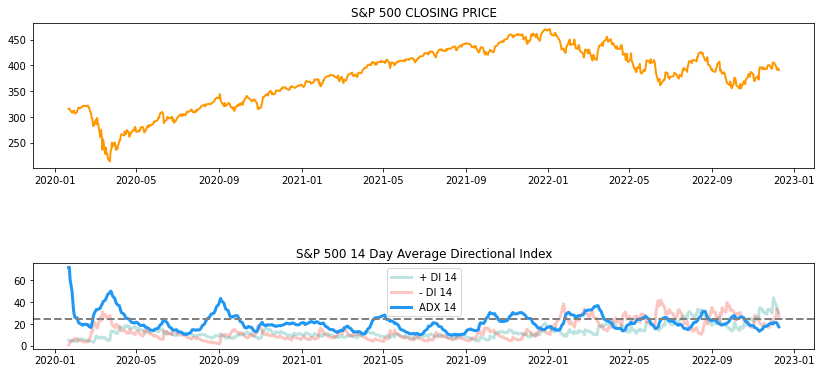

In [ ]:
plotting_relevant_data(relevant_data)

##Strategy

When<br> 
ADI crosses above 25 and $+DI > -DI$, buy.<br>
ADI crosses above 25 and $+DI < -DI$, sell.

In [ ]:
def generating_trading_signals_adi(data):

  #creates signals dataframe which is used to plot trading signals and and calculate CAGR 

  signal = pd.DataFrame()
  signal['Close'] = data['Adj Close']
  signal['+ DI'] = data['+ DI']
  signal['- DI'] = data['- DI']
  signal['average DI'] = data['average DI']
  buy_price = []
  sell_price = []

  for i in range(0, len(data)):

    if signal['average DI'][i] > 25 and (signal['average DI'].shift(1))[i] < 25:

      if signal['+ DI'][i] > signal['- DI'][i]:
        
        buy_price.append(signal['Close'][i])
        sell_price.append(np.nan)

      elif signal['+ DI'][i] < signal['- DI'][i]:

        buy_price.append(np.nan)
        sell_price.append(signal['Close'][i])

      else:

        buy_price.append(np.nan)
        sell_price.append(np.nan)

    else:

      buy_price.append(np.nan)
      sell_price.append(np.nan)

  signal['Buy'] = buy_price
  signal['Sell'] = sell_price
  
  return signal

In [ ]:
signals = generating_trading_signals_adi(relevant_data)
signals

,Close,+ DI,- DI,average DI,Buy,Sell
Date,,,,,,
2020-01-22,315.862671,5.087614,0.753459,71.900435,NaN,NaN
2020-01-23,316.224976,4.580557,1.812728,71.948734,NaN,NaN
2020-01-24,313.412720,4.289821,2.873524,61.078769,NaN,NaN
2020-01-27,308.388947,3.940879,5.506010,49.513553,NaN,NaN
2020-01-28,311.620483,5.079183,4.877393,41.673879,NaN,NaN
...,...,...,...,...,...,...
2022-12-05,397.763458,37.546636,27.634809,21.394855,NaN,NaN
2022-12-06,392.029785,35.142980,33.931421,20.884195,NaN,NaN
2022-12-07,391.362854,32.360950,31.245303,19.517752,NaN,NaN


##Plotting Trading Signals

In [ ]:
def plotting_trading_signals_adi(data):
  
  #Plots relevant columns from signals
  plt.figure(figsize=(14, 6))
  ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
  ax2 = plt.subplot2grid((11,1), (8,0), rowspan = 5, colspan = 1)

  ax1.plot(data['Close'], linewidth = 2, color = '#ff9800')
  ax1.scatter(data.index, data['Buy'], c='green', label='Buy Signal', marker='^')
  ax1.scatter(data.index, data['Sell'], c='red', label='Sell Signal', marker='v')

  ax1.set_title('S&P 500 CLOSING PRICE with trading signals')

  ax2.plot(data['+ DI'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
  ax2.plot(data['- DI'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
  ax2.plot(data['average DI'], color = '#2196f3', label = 'ADX 14', linewidth = 3)

  ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')

  ax2.legend()

  ax2.set_title('S&P 500 14 Day Average Directional Index')

  plt.show()

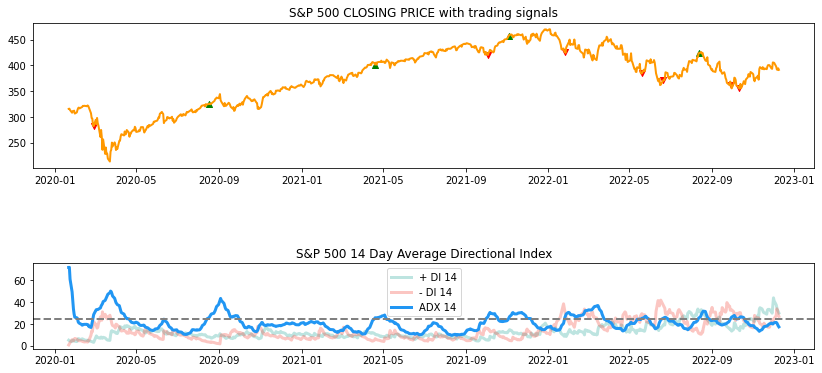

In [ ]:
plotting_trading_signals_adi(signals)

##Calculating and Printing CAGR

In [ ]:
print('CAGR =', profit_and_loss_calculation(signals), '%')

CAGR = -36.94975098809273 %


# Donchain Channels

In [ ]:
data = ['SPY']
df = get_stock_data(data)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-10,313.820007,314.549988,312.809998,313.529999,297.422272,52649800
2019-12-11,314.029999,314.700012,313.440002,314.420013,298.266571,53429100
2019-12-12,314.429993,317.989990,314.170013,317.130005,300.837341,96389600
2019-12-13,316.869995,318.670013,316.019989,317.320007,301.017578,81503900
2019-12-16,319.220001,320.149994,317.250000,319.500000,303.085602,82749700


In [ ]:
df['Upper_Channel_Line'] = pd.Series.rolling(df['High'], window=20).max()
df['Lower_Channel_Line'] = pd.Series.rolling(df['Low'], window=20).min()
df['Middle_Channel_Line'] = (df['Upper_Channel_Line'] + df['Lower_Channel_Line'])/2
df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume,Upper_Channel_Line,Lower_Channel_Line,Middle_Channel_Line
Date,,,,,,,,,
2020-01-08,322.940002,325.779999,322.670013,324.450012,309.294525,68296000,325.779999,312.809998,319.294998
2020-01-09,326.160004,326.730011,325.519989,326.649994,311.391724,48473300,326.730011,313.440002,320.085007
2020-01-10,327.290009,327.459991,325.200012,325.709991,310.495667,53029300,327.459991,314.170013,320.815002
2020-01-13,326.390015,327.959991,325.920013,327.950012,312.631073,47086800,327.959991,316.019989,321.989990
2020-01-14,327.470001,328.619995,326.839996,327.450012,312.154449,62832800,328.619995,317.250000,322.934998


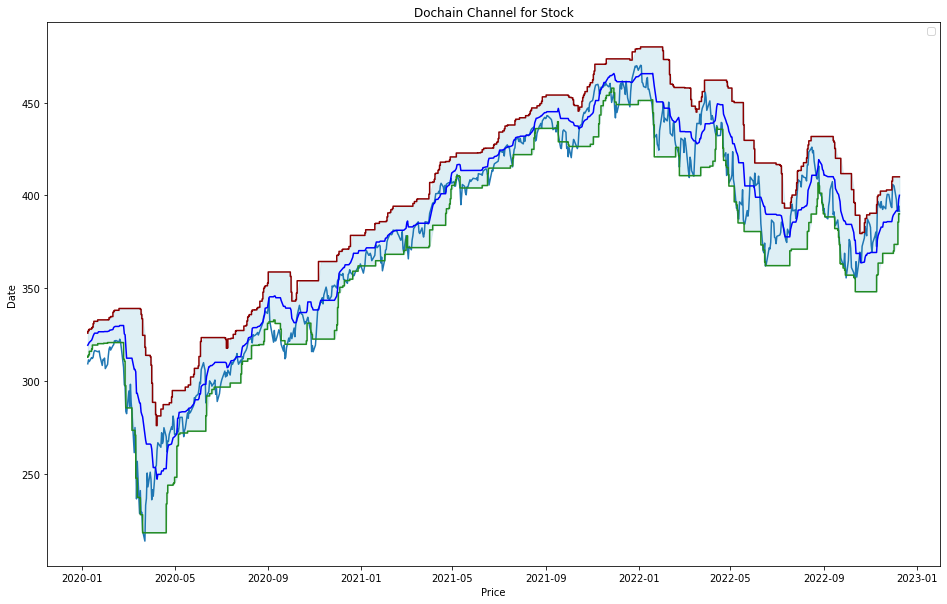

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(df['Adj Close'])
plt.fill_between(df.index, df['Lower_Channel_Line'], df['Upper_Channel_Line'],  color='lightblue', alpha=0.4)
plt.plot(df['Upper_Channel_Line'], c='darkred', linestyle='-', drawstyle="steps")
plt.plot(df['Lower_Channel_Line'], c='forestgreen', linestyle='-', drawstyle="steps")
plt.plot(df['Middle_Channel_Line'], c='blue', linestyle='-')
plt.title('Dochain Channel for Stock')
plt.legend(loc='best')
plt.xlabel('Price')
plt.ylabel('Date')
plt.show()

In [ ]:
def generating_trading_signals(df): 

  signal = pd.DataFrame()
  signal['Close'] = df['Close']
  signal['UC'] = df['Upper_Channel_Line']
  signal['LC'] = df['Lower_Channel_Line']
  buy_price = []
  sell_price = []

  flag = False

  for i in range(0, len(signal['Close'])):

    if signal['Close'][i] > signal['UC'][i-1] and flag == False:
      buy_price.append(signal['Close'][i])
      sell_price.append(np.nan)
      flag = True

    elif signal['Close'][i] < signal['LC'][i-1] and flag == True:
      buy_price.append(np.nan)
      sell_price.append(signal['Close'][i])
      flag = False

    else:
      buy_price.append(np.nan)
      sell_price.append(np.nan)

  signal['Buy'] = buy_price
  signal['Sell'] = sell_price
  
  return signal

In [ ]:
signals_d=generating_trading_signals(df)
signals_d

,Close,UC,LC,Buy,Sell
Date,,,,,
2020-01-08,324.450012,325.779999,312.809998,NaN,NaN
2020-01-09,326.649994,326.730011,313.440002,326.649994,NaN
2020-01-10,325.709991,327.459991,314.170013,NaN,NaN
2020-01-13,327.950012,327.959991,316.019989,NaN,NaN
2020-01-14,327.450012,328.619995,317.250000,NaN,NaN
...,...,...,...,...,...
2022-12-05,399.589996,410.000000,373.609985,NaN,NaN
2022-12-06,393.829987,410.000000,373.609985,NaN,NaN
2022-12-07,393.160004,410.000000,373.609985,NaN,NaN


In [ ]:
def plotting_signals_data(signals_d): # plots important columns from signal

  plt.figure(figsize=(14,6),)
  l1 = plt.plot(signals_d['Close'], c='blue', alpha=0.4)
  l2 = plt.plot(signals_d['UC'], c='red', alpha=0.4)
  l3 = plt.plot(signals_d['LC'], c='green', alpha=0.4)
  plt.scatter(signals_d.index, signals_d['Buy'], c='green', label='Buy Signal', marker='^')
  plt.scatter(signals_d.index, signals_d['Sell'], c='red', label='Sell Signal', marker='v')
  plt.ylabel('Stock Closing Price')
  plt.xlabel('Date')
  plt.title('Sell Signal Plot')
  plt.legend(['Stock Closing Price', 'Upper Donchian Channel', 'Lower Donchian Channel'], loc='upper left');

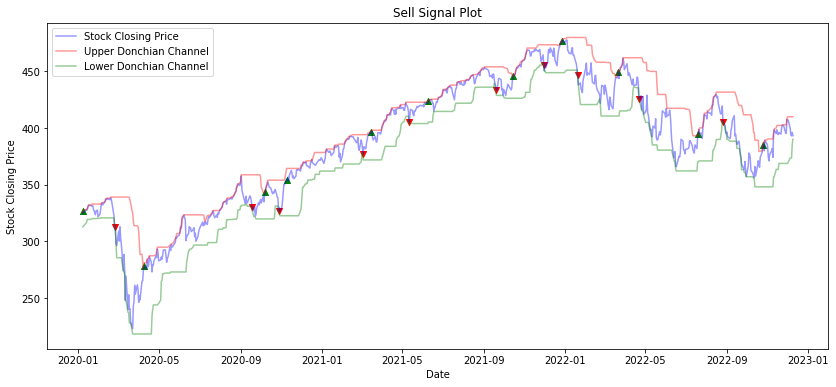

In [ ]:
plotting_signals_data(signals_d)

In [ ]:
def profit_and_loss_calculation(signals_d): # calculated CAGR with signal dataframe

  #In this function i assume that we start off with a capital of 100,000
  #Upon encountering a buy signal no_of_stocks amount of stocks are bought
  #Upon encountering a sell signal no_of_stocks amount of stocks are sold
  #In the end of the simulation, all stocks held are sold off at the current market price
  initial_capital = 100000
  no_of_stocks = initial_capital // max(signals_d['Close'])
  assets_in_cash = 100000
  stocks_held = 0
  buy_check = signals_d['Buy'].isna()
  sell_check = signals_d['Sell'].isna()

  for i in range(0, len(signals_d)):
    
    if buy_check[i] == False:
      assets_in_cash -= no_of_stocks * signals_d['Buy'][i]
      stocks_held += no_of_stocks

    if sell_check[i] == False:
      assets_in_cash += no_of_stocks * signals_d['Sell'][i]
      stocks_held -= no_of_stocks

  final_assets = assets_in_cash + stocks_held * signals_d['Close'][len(signals_d) - 1]
  no_of_days = (signals_d.index[-1] - signals_d.index[0]).days
  returns = ((final_assets / initial_capital) ** (float(no_of_days) / (3 * 365)) - 1) * 100
  
  return returns

In [ ]:
print('CAGR =', profit_and_loss_calculation(signals_d), '%')

CAGR = 7.60800772081176 %


# Commodity Channel Index

In [ ]:
data = ['SPY']
df = get_stock_data(data)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-10,313.820007,314.549988,312.809998,313.529999,297.422333,52649800
2019-12-11,314.029999,314.700012,313.440002,314.420013,298.266632,53429100
2019-12-12,314.429993,317.989990,314.170013,317.130005,300.837402,96389600
2019-12-13,316.869995,318.670013,316.019989,317.320007,301.017670,81503900
2019-12-16,319.220001,320.149994,317.250000,319.500000,303.085663,82749700


In [ ]:
n = 20
df['TP'] = (df['High'] + df['Low'] + df['Adj Close'])/3
df['SMA_TP'] = df['TP'].rolling(n).mean()
df['SMA_STD'] = df['TP'].rolling(n).std()
df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015*df['SMA_STD'])
df = df.drop(['TP', 'SMA_TP', 'SMA_STD'],axis=1)

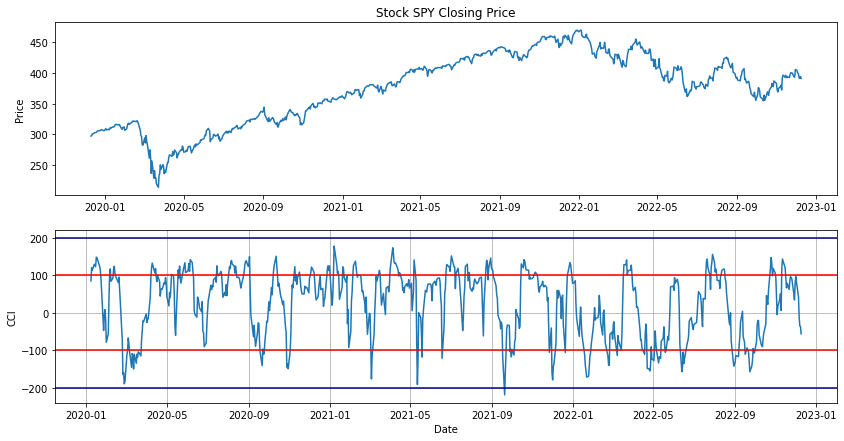

In [ ]:
symbol='SPY'
fig = plt.figure(figsize=(14,7))
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df['Adj Close'])
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['CCI'], label='Commodity Channel Index')
ax2.axhline(y=100, color='red')
ax2.axhline(y=-100, color='red')
ax2.axhline(y=200, color='darkblue')
ax2.axhline(y=-200, color='darkblue')
ax2.grid()
ax2.set_ylabel('CCI')
ax2.set_xlabel('Date')
plt.show()

In [ ]:
def implement_cci_strategy(prices, cci):
    buy_price = []
    sell_price = []
    cci_signal = []
    signal = 0
    
    lower_band = (-100)
    upper_band = 100
    
    for i in range(len(prices)):
        if cci[i-1] > lower_band and cci[i] < lower_band:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                cci_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                cci_signal.append(0)
                
        elif cci[i-1] < upper_band and cci[i] > upper_band:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                cci_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                cci_signal.append(0)
                
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            cci_signal.append(0)
            
    return buy_price, sell_price, cci_signal

buy_price, sell_price, cci_signal = implement_cci_strategy(df['Close'], df['CCI'])

signals_cci=pd.DataFrame()
signals_cci['Close']=df['Close']
signals_cci['Buy_c']=buy_price
signals_cci['Sell_c']=sell_price


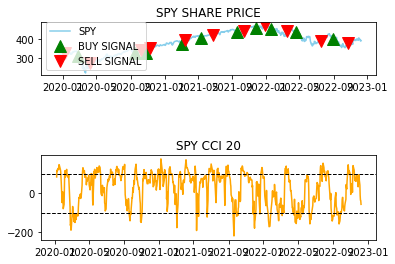

In [ ]:
ax1 = plt.subplot2grid((20,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((10,1), (6,0), rowspan = 4, colspan = 1)
ax1.plot(signals_cci['Close'], color = 'skyblue', label = 'SPY')
ax1.plot(signals_cci.index, buy_price, marker = '^', markersize = 12, linewidth = 0, label = 'BUY SIGNAL', color = 'green')
ax1.plot(signals_cci.index, sell_price, marker = 'v', markersize = 12, linewidth = 0, label = 'SELL SIGNAL', color = 'r')
ax1.set_title('SPY SHARE PRICE')
ax1.legend()
ax2.plot(df['CCI'], color = 'orange')
ax2.set_title('SPY CCI 20')
ax2.axhline(100, linestyle = '--', linewidth = 1, color = 'black')
ax2.axhline(-100, linestyle = '--', linewidth = 1, color = 'black')
plt.show()

KeyError: ignored

<Figure size 1008x432 with 0 Axes>